## <span style='color:Blue'> Web Scrapping NSE website using BeautifulSoup

The objective is to do a trending analysis of NSE Advance Decline Ratio. A sample image of what we are trying to read from NSE.

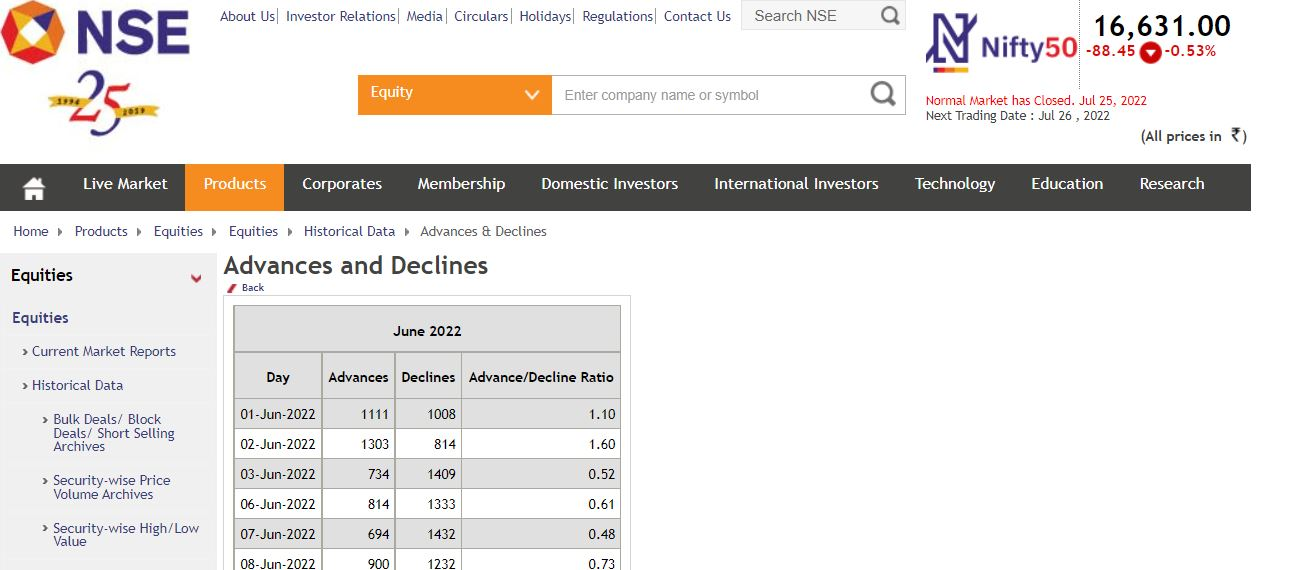




As a start upgrade pandas package to 1.4.3

In [1]:
#pip install pandas == 1.4.3


I always like ignoring warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

The user has to provide:
1. start_date

The end_date is chosen to be the current date

Based on start and end date we are going to use pandas package pd.bdate_range to create a date_list variable. The date_list variable will be used to create dynamic links in the for loop below

In [3]:
from datetime import datetime
import pandas as pd

start_date = datetime(2012,1,1)
end_date = datetime.today()

date_list = pd.bdate_range(start_date,end_date , freq = 'M').strftime("%b%Y")
date_list = date_list.str.lower()


1. Create an empty dataframe df
2. Create dynamic url using the date_list variable.
3. Use beautiful soup to parse through the HTML
4. Create 4 variable date,adv,dec,adv_dec_ratio
5. Append the ouput to empty dataframe df

In [4]:
import requests
import json
from requests.auth import HTTPBasicAuth


from bs4 import BeautifulSoup

df = pd.DataFrame()

for i in date_list:
    url = 'https://www1.nseindia.com/products/content/equities/equities/eq_advdec'+ i + '.htm'
    headers = {'User-Agent': 'Mozilla/5.0'}
    page = requests.get(url,headers=headers,auth=HTTPBasicAuth('user', 'pass'))
    soup = BeautifulSoup(page.text, 'html.parser')
    
    table = soup.find('table')
    rows = table.find_all('tr')
    
    for row in rows:
        try:
            date = row.find('td',attrs = {'class':'date'}).get_text()
            adv = int(row.find_all('td',attrs = {'class':'number'})[0].get_text())
            dec = int(row.find_all('td',attrs = {'class':'number'})[1].get_text())
            adv_dec_ratio = float(row.find_all('td',attrs = {'class':'number'})[2].get_text())
            output = pd.DataFrame([[date,adv,dec,adv_dec_ratio]],columns=['Date','Adv','Dec','Adv_Dec_Ratio'])
            df = df.append(output)
        except:
            pass



Wait!!! Wr are still not done here. The advance decline ratio only has data till the end of last month.
What about the current month?
It happens we need a seperate process to extract advance/decline ratio for the current month


In [5]:
df.tail(n=2)

,Date,Adv,Dec,Adv_Dec_Ratio
0,29-Jun-2022,848,1257,0.67
0,30-Jun-2022,755,1357,0.56


As a start we are going to create a date list for the current month

In [6]:
current_month_date_list = pd.bdate_range(datetime(end_date.year,end_date.month,1),end_date, freq = 'd').strftime("%d%m%y")

We are going to access the NSE Market Activity Report by creating dynamic url
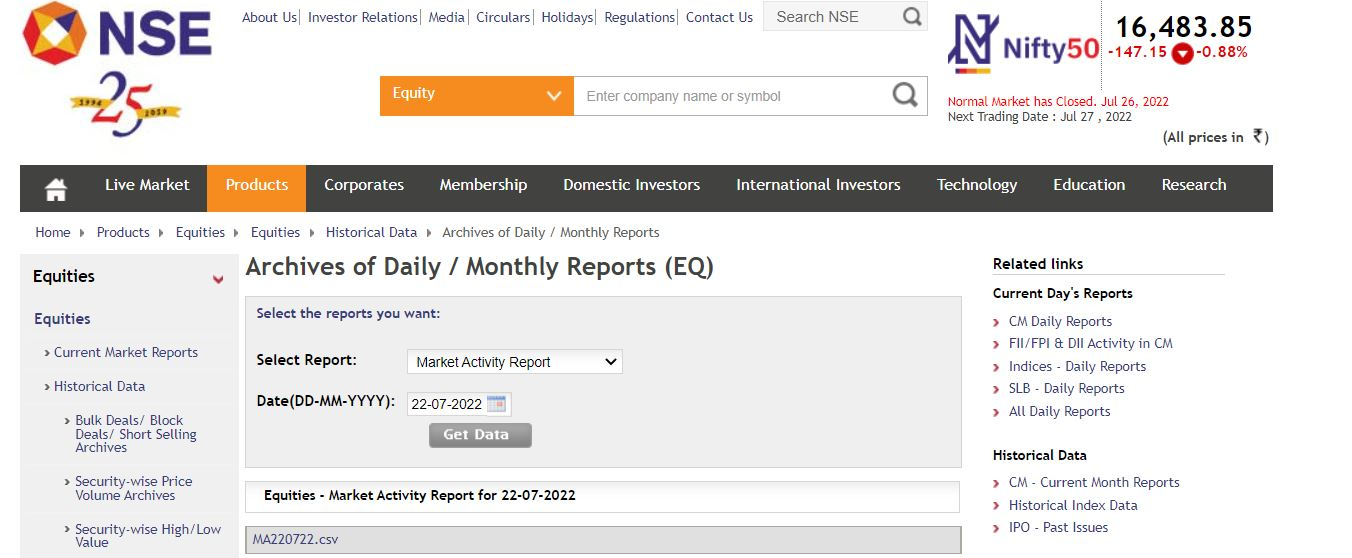

From each such csv file we are going to access row 82 and 83 and store it in dataframe current month output
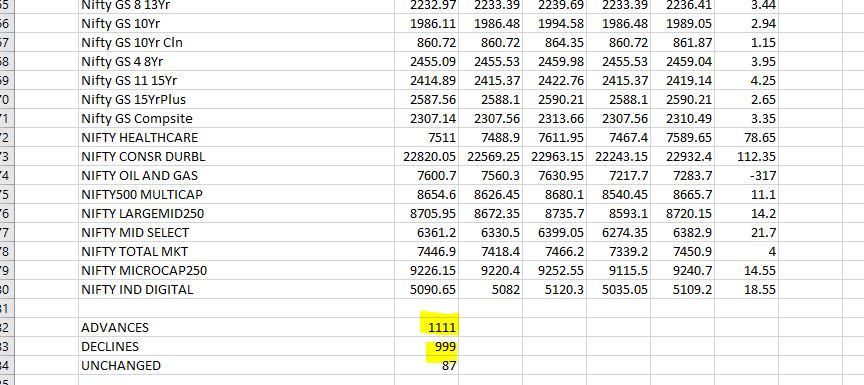

In [7]:
import requests
import csv

current_month_output = pd.DataFrame()

for i in current_month_date_list:
    try:
        url  = 'https://www1.nseindia.com/archives/equities/mkt/MA'+i+'.csv'
        Date = pd.read_csv(url, skiprows=0,nrows=1,usecols = [1,1],header = None).values[0][0]
        #print(Date)
        Adv  = pd.read_csv(url, skiprows=80,nrows=1,usecols = [2,2],header = None).values[0][0]
        Dec  = pd.read_csv(url, skiprows=82,nrows=1,usecols = [2,2],header = None).values[0][0]
        Adv_Dec_Ratio = Adv/Dec
        #print(Date,Adv,Dec,Adv_Dec_Ratio)
        output = pd.DataFrame([[Date,Adv,Dec,Adv_Dec_Ratio]],columns=['Date','Adv','Dec','Adv_Dec_Ratio'])
        current_month_output = current_month_output.append(output)
    except:
        pass

In [8]:
current_month_output.head(n = 5)

,Date,Adv,Dec,Adv_Dec_Ratio
0,01-Jul-2022,1111,999,1.112112
0,04-Jul-2022,1345,803,1.674969
0,05-Jul-2022,1063,1037,1.025072
0,06-Jul-2022,1219,902,1.351441
0,07-Jul-2022,1486,631,2.354992


Appending the master df with the current month output data

In [9]:
df = df.append(current_month_output)

In [10]:
df.tail(n = 5)

,Date,Adv,Dec,Adv_Dec_Ratio
0,20-Jul-2022,1228,899,1.365962
0,21-Jul-2022,1300,824,1.577670
0,22-Jul-2022,1130,988,1.143725
0,25-Jul-2022,882,1290,0.683721
0,26-Jul-2022,582,1543,0.377187


1. Converting the date variable from format string to date
2. I recalculate the advance decline ratio as the figures from NSE for 2014 are incorrect


In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df['Adv_Dec_Ratio_Recalc'] = df['Adv']/df['Dec']

In [12]:
df[df['Date']>= '2014-01-01'].head(5)


,Date,Adv,Dec,Adv_Dec_Ratio,Adv_Dec_Ratio_Recalc
0,2014-01-01,957,413,86.0,2.317191
0,2014-01-02,422,980,66.0,0.430612
0,2014-01-03,705,640,85.0,1.101562
0,2014-01-06,796,565,92.0,1.408850
0,2014-01-07,626,738,105.0,0.848238


Plot a simple line chart of the Adv_Ratio variable. There is a lot of noise and does not provide valuable information

<AxesSubplot:xlabel='Date'>

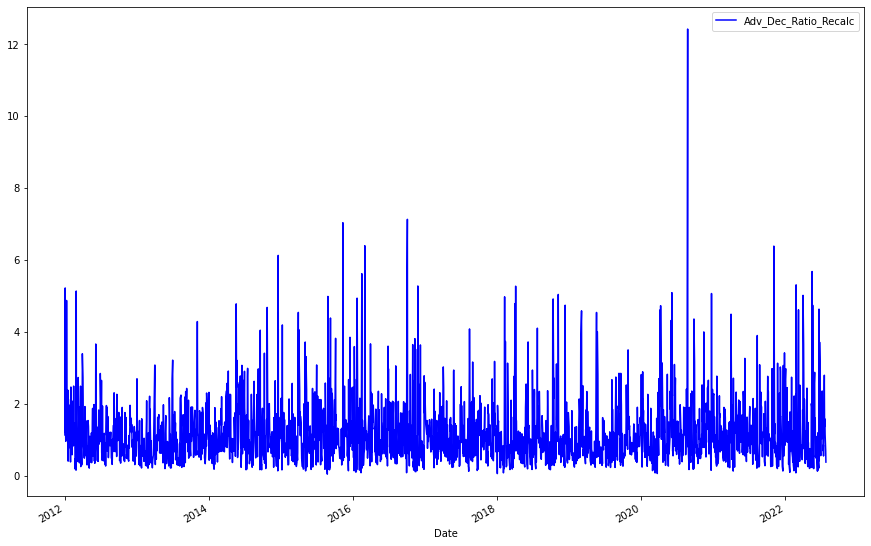

In [13]:
df.plot(x = 'Date' , y = 'Adv_Dec_Ratio_Recalc' , figsize = (15,10) , color = 'blue')

To smoothen the series I use a 22(approx 1 month) day moving average of the series.

In [14]:
import numpy as np
df['Mean_Adv_Dec_Ratio'] = df['Adv_Dec_Ratio_Recalc'].rolling(22,1).mean()

In [15]:
df.tail(n= 20)

,Date,Adv,Dec,Adv_Dec_Ratio,Adv_Dec_Ratio_Recalc,Mean_Adv_Dec_Ratio
0,2022-06-29,848,1257,0.670000,0.674622,1.190518
0,2022-06-30,755,1357,0.560000,0.556374,1.164024
0,2022-07-01,1111,999,1.112112,1.112112,1.164475
0,2022-07-04,1345,803,1.674969,1.674969,1.167849
0,2022-07-05,1063,1037,1.025072,1.025072,1.190765
0,2022-07-06,1219,902,1.351441,1.351441,1.224437
0,2022-07-07,1486,631,2.354992,2.354992,1.309453
0,2022-07-08,1156,948,1.219409,1.219409,1.331675
0,2022-07-11,1351,778,1.736504,1.736504,1.361094
0,2022-07-12,865,1243,0.695897,0.695897,1.372051


<AxesSubplot:xlabel='Date'>

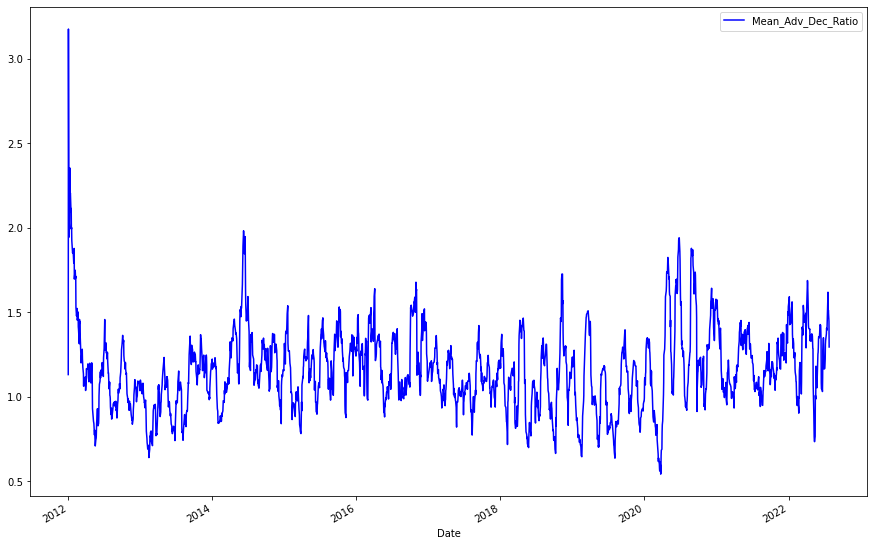

In [16]:
df.plot(x = 'Date' , y = 'Mean_Adv_Dec_Ratio' , figsize = (15,10) , color = 'blue')

One other way to visualize the time series will be through a heatmap.
Hence i proceed creating a matrix x indexed by month with column being indexed by year. 


In [17]:
x = pd.pivot_table(df,values = 'Mean_Adv_Dec_Ratio',index = df['Date'].dt.strftime('%m') , columns = df['Date'].dt.strftime('%Y'))

In [18]:
x.head(n=5)

Date,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Date,,,,,,,,,,,
01,2.056421,1.013308,1.111623,1.320023,1.286427,1.167292,1.153496,1.018416,1.243705,1.361189,1.441153
02,1.552508,0.726587,0.887583,0.969440,1.169832,1.208436,1.005645,0.781086,0.952608,1.046068,1.059921
03,1.180760,0.858573,1.077184,0.923549,1.412364,1.012126,0.994171,1.413412,0.669855,1.060714,1.350165
04,1.146453,1.028120,1.352599,1.221896,1.342300,1.227297,1.357581,1.085899,1.458468,1.209669,1.453652
05,0.849998,1.049911,1.326499,1.211227,1.057416,1.014520,0.854038,0.885798,1.314300,1.352639,1.045746


Here is my heatmap. The whitespaces in the map are basically holidays or non trading days

Text(0.5, 1.0, 'Advance Decline Ratio HeatMap Rolling 22d Average')

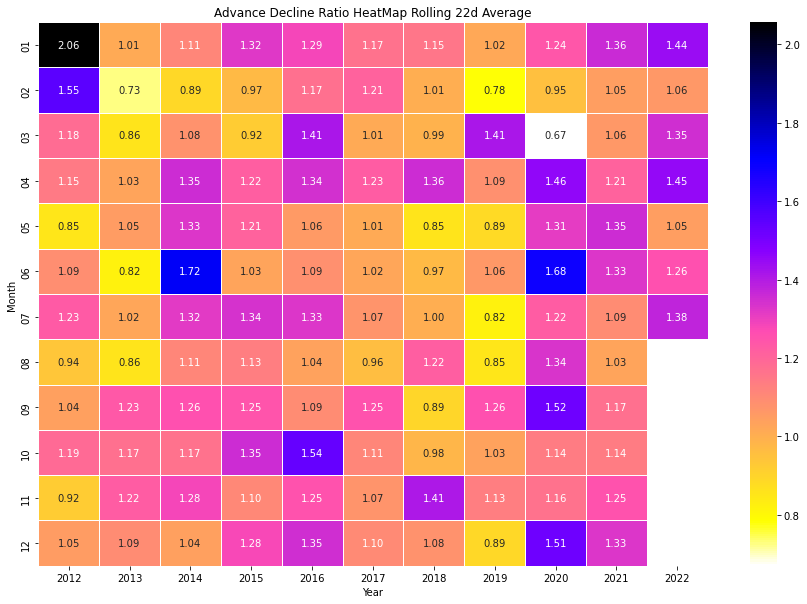

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
sns.heatmap(x, annot = True, fmt = '.2f' ,cmap = 'gnuplot2_r' , linewidth = 1)
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Advance Decline Ratio HeatMap Rolling 22d Average')